<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

## Project Overview and Import Libraries

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Oct  8 06:12:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


####Helper Function


In [11]:
import numpy as np

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


## Load and Preprocess the Data

In [12]:
import os

file_lacation = '/content/drive/My Drive/Deep learning Model/GANs/data'

In [13]:
import random

images_loaction = os.path.join(file_lacation,'img_align_celeba')
dataset = os.listdir(images_loaction)

print(dataset[:5])

['042429.jpg', '042430.jpg', '042431.jpg', '042432.jpg', '042433.jpg']


In [14]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

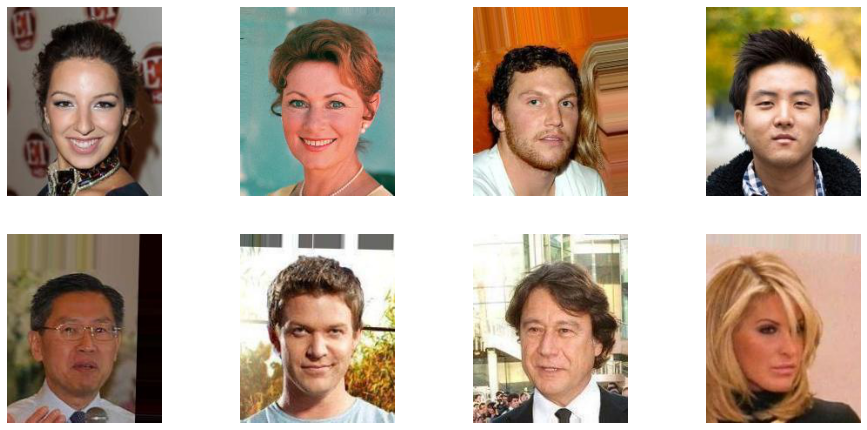

In [15]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

images = [os.path.join(images_loaction, fname) 
                for fname in dataset[ pic_index-8:pic_index] 
               ]

for i, img_path in enumerate(images):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_set = train_datagen.flow_from_directory(
    file_lacation,
    target_size=(250, 250),
    batch_size=batch_size,
    class_mode="binary",
    subset='training') # set as training data

validation_set = train_datagen.flow_from_directory(
    file_lacation, # same directory as training data
    target_size=(250, 250),
    batch_size=batch_size,
    class_mode="binary",
    subset='validation') # set as validation data


Found 34743 images belonging to 1 classes.
Found 8685 images belonging to 1 classes.


## Build the Generator Network for DCGAN

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [17]:
num_features = 256

generator = keras.models.Sequential([                                    
    keras.layers.Dense(4*4*128, input_shape=[num_features]),
    keras.layers.Reshape([4,4,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(512,(5,5),(1,1), padding = 'same',activation='relu', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(256,(5,5),(2,2), padding = 'same',activation='relu', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128,(5,5),(2,2), padding = 'same',activation='relu', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5),(2,2), padding = 'same',activation='relu', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32,(5,5),(2,2), padding = 'same',activation='relu', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='tanh')                                
])


In [6]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              526336    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TensorShape([1, 64, 64, 3])

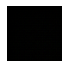

In [5]:
noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise, training=False)
show(generated_image, 1)
generated_image.shape

## Build the Discriminator Network for DCGAN

In [18]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64,(5,5),(1,1), padding='same', input_shape=[64,64,3]),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64,(5,5),(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128,(5,5),(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256,(5,5),(2,2), padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [53]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5001005]], shape=(1, 1), dtype=float32)


## Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [23]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan = keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentrop', optimizer='rmsprop')

## Define Training Procedure

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train DCGAN

## Generate Synthetic Images with DCGAN

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)